In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images, inverse_scale_image

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-04-11 15:48:52.846749: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-04-11 15:53:06.678159: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-11 15:53:07.254223: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-11 15:53:08.024421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-04-11 15:53:08.024465: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-11 15:53:11.114016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-11 15:53:11.114089: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-0

## CESM Data

In [3]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images(dir_name)
data_socat, pco2_socat = preprocess_images(dir_name, socat = True)

val_data,val_pco2 = preprocess_images(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images(val_dir_name,"035",socat=True)

INPUT_SHAPE=data_socat[0].shape
OUTPUT_SHAPE=pco2_socat[0].shape

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [29]:
base_model = tf.keras.models.load_model('../../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})
pred = base_model.predict(val_data,verbose=True)

14/14 [==============================] - 13s 291ms/step


In [30]:
def inverse_scale_image(arr, df, socat=False):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    if socat:
        return inverse_scale_image_socat(arr, df)
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    y_true=np.nan_to_num(df)
    y_pred[y_true==0]=0
    #y_true = np.expand_dims(y_true, axis=3)

    return y_true,y_pred

In [31]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name,num="035")
y_true,y_pred = inverse_scale_image(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0



In [35]:
print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())



Full RMSE score:
tf.Tensor(18.06549453128874, shape=(), dtype=float64)
SOCAT RMSE score:
tf.Tensor(18.366727698038456, shape=(), dtype=float64)


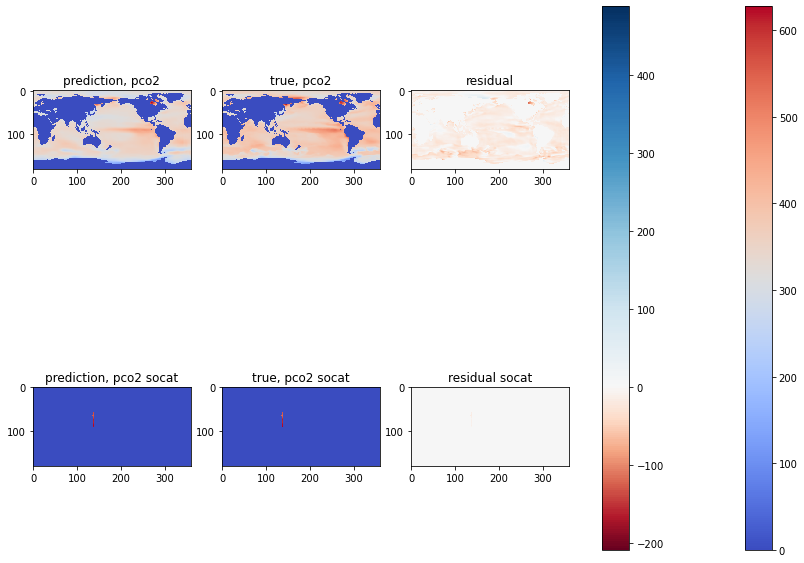

In [32]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

In [36]:
rmses = []
rmses_socat = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)
    

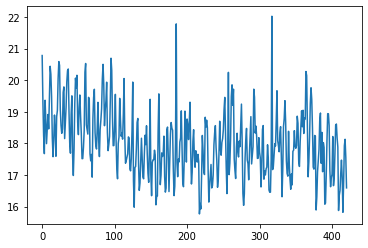

In [38]:
plt.plot(rmses)

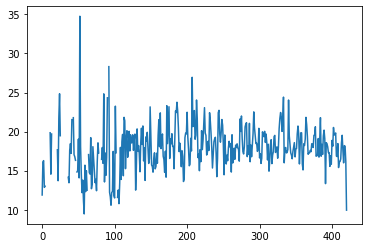

In [39]:
plt.plot(rmses_socat)

## MPI

In [47]:
def read_xarray(dir_name="",num="001",mpi=False,can=False):
    '''
     read_xarray(dir)name) opens data and returns data in xarray format for each feature
    '''
    file_type = "CESM"
    if mpi:
        file_type ="MPI006"
        num=""
    elif can:
        file_type = "CanESM2r1r10"
        num=""
        
    
    chl = xr.open_dataset(f'{dir_name}/Chl_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    mld = xr.open_dataset(f'{dir_name}/MLD_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    sss = xr.open_dataset(f'{dir_name}/SSS_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    sst = xr.open_dataset(f'{dir_name}/SST_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    u10 = xr.open_dataset(f'{dir_name}/U10_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    xco2 = xr.open_dataset(f'../../data/data1/XCO2_1D_mon_CESM001_native_198201-201701.nc')

    icefrac = xr.open_dataset(f'{dir_name}/iceFrac_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    patm = xr.open_dataset(f'{dir_name}/pATM_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    pco2 = xr.open_dataset(f'{dir_name}/pCO2_2D_mon_{file_type}{num}_1x1_198201-201701.nc')

    return chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2

def preprocess_images(dir_name, num="001",socat=False,mpi=False,can=False):
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num,mpi,can)
    
    if socat:

        chl_images = preprocess_image_reduced(chl.Chl_socat.data)
        mld_images = preprocess_image_reduced(mld.MLD_socat.data)
        sss_images = preprocess_image_reduced(sss.SSS_socat.data)
        sst_images = preprocess_image_reduced(sst.SST_socat.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2_socat.data)
    
    else:
        chl_images = preprocess_image_reduced(chl.Chl.data)
        mld_images = preprocess_image_reduced(mld.MLD.data)
        sss_images = preprocess_image_reduced(sss.SSS.data)
        sst_images = preprocess_image_reduced(sst.SST.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2.data)
    
    X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X = X.reshape((421,180,360,5),order='F')

    return X, pco2_images

In [48]:
mpi_dir_name = "../../data/mpi_001"


data,pco2 = preprocess_images(mpi_dir_name,mpi=True)
data_socat, pco2_socat = preprocess_images(mpi_dir_name, socat = True,mpi=True)


pred = base_model.predict(data,verbose=True)

14/14 [==============================] - 1s 111ms/step


In [50]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name,num="035")
y_true,y_pred = inverse_scale_image(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat = np.nan_to_num(pco2t2.pCO2_socat.data)
y_pred_socat[y_true_socat==0]=0.0



In [51]:
print("Full RMSE score:")
a=custom_rmse(y_pred,y_true)
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat,y_true_socat)
print(b.numpy())




Full RMSE score:
44.65722342859224
SOCAT RMSE score:
45.03653630421236


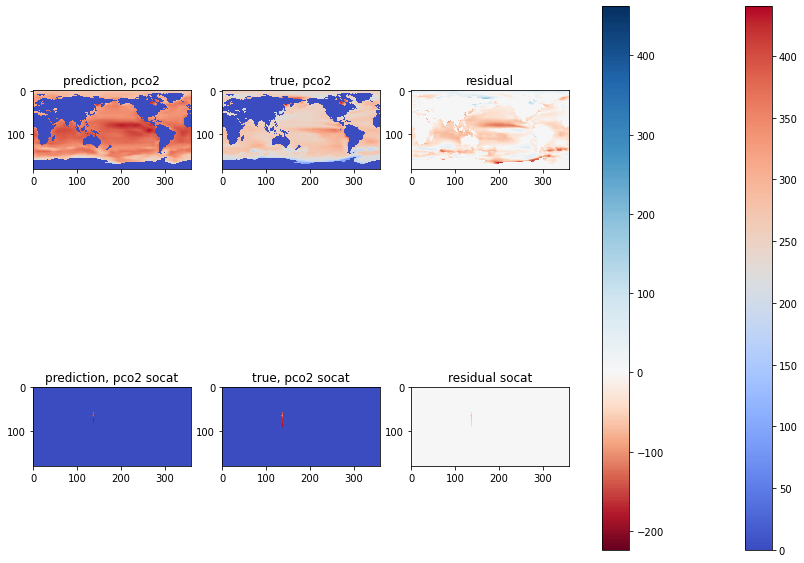

In [52]:
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 3,figsize=(15, 10))

d = y_true - y_pred

norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)

img=axis[0][0].imshow(np.flipud(y_pred[0]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction, pco2")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true, pco2")

diff=np.flipud(np.squeeze(y_true[0]-y_pred[0]))
img2=axis[0][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[0][2].set_title("residual")
plt.colorbar(img2,ax=axis)


img3=axis[1][0].imshow(np.flipud(y_pred_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][0].set_title("prediction, pco2 socat")

img4=axis[1][1].imshow(np.flipud(y_true_socat[0]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("true, pco2 socat")

diff=np.flipud(np.squeeze(y_true_socat[0]-y_pred_socat[0]))

img5=axis[1][2].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][2].set_title("residual socat")

plt.show()

In [53]:
rmses = []
rmses_socat = []

for i in range(421):    
    rmse =custom_rmse(y_pred[i],y_true[i]).numpy()
    rmses.append(rmse)
    rmse =custom_rmse(y_pred_socat[i],y_true_socat[i]).numpy()
    rmses_socat.append(rmse)
    

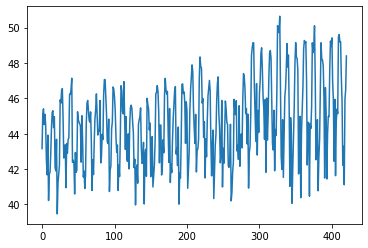

In [54]:
plt.plot(rmses)

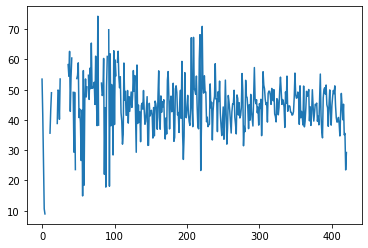

In [55]:
plt.plot(rmses_socat)